In [1]:
!wget --no-check-certificate \
    https://github.com/0xOMEGA/Covid19Keras/archive/main.zip \
    -O /tmp/main.zip

--2021-01-02 17:02:19--  https://github.com/0xOMEGA/Covid19Keras/archive/main.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/0xOMEGA/Covid19Keras/zip/main [following]
--2021-01-02 17:02:19--  https://codeload.github.com/0xOMEGA/Covid19Keras/zip/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/main.zip’

/tmp/main.zip           [                 <=>]   1.27G  27.0MB/s    in 49s     

2021-01-02 17:03:08 (26.4 MB/s) - ‘/tmp/main.zip’ saved [1366592044]



In [2]:
import os
import zipfile

local_zip = '/tmp/main.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
# Directory with our training dandelion pictures
positive_dir = os.path.join('/tmp/Covid19Keras-main/positive')

# Directory with our training grass pictures
negative_dir = os.path.join('/tmp/Covid19Keras-main/negative')

In [4]:
positive_file_names = os.listdir(positive_dir)
print(positive_file_names[:10])

negative_file_names = os.listdir(negative_dir)
print(negative_file_names[:10])


['000012-1.jpg', '16630_2_2.jpg', 'ba45a47c3ef5060ec39891046be7ca_jumbo.jpg', '353889E0-A1E8-4F9E-A0B8-F24F36BCFBFB.jpeg', 'b0f1684d1ee90dc09deef015e29dae_jumbo.jpeg', '16673_2_1.jpg', '3a81faf3.jpg', '11547_2020_1203_Fig1_HTML-a.png', '16745_7_1.png', 'bf551b8b.jpg']
['IM-0517-0001-0001.jpeg', 'IM-0466-0001.jpeg', 'IM-0292-0001.jpeg', 'NORMAL2-IM-0971-0001-0001.jpeg', 'IM-0408-0001.jpeg', 'NORMAL2-IM-1342-0001.jpeg', 'IM-0640-0001-0001.jpeg', 'NORMAL2-IM-1222-0001.jpeg', 'NORMAL2-IM-0547-0001.jpeg', 'IM-0201-0001.jpeg']


In [5]:
print('total covid positive images:', len(os.listdir(positive_dir)))
print('total covid negative images:', len(os.listdir(negative_dir)))

total covid positive images: 930
total covid negative images: 1349


#### Ön İşleme
Gerekli biçimlendirme işlemleri uygulanıyor, 224x224 olarak yeniden boyutlandırılıp doğrulama ve eğitim için iki parçaya ayrılıyor.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255, validation_split=.1)

train_generator = datagen.flow_from_directory(
        '/tmp/Covid19Keras-main/',  
        classes = ['positive', 'negative'],
        target_size=(224, 224), 
        batch_size=240,
        class_mode='binary',
        subset='training')

validation_generator = datagen.flow_from_directory(
        '/tmp/Covid19Keras-main/', 
        classes = ['positive', 'negative'],
        target_size=(224, 224), 
        batch_size=25,
        class_mode='binary',
        subset='validation',
        shuffle=False)

Found 2052 images belonging to 2 classes.
Found 227 images belonging to 2 classes.


In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [8]:
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (224,224,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               19267712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 19,267,841
Trainable params: 19,267,841
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-2),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# history = model.fit(
#       train_generator,
#       steps_per_epoch=8,  
#       epochs=15,
#       verbose=1,
#       validation_data = validation_generator,
#       validation_steps=8)

history = model.fit(train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 51s 6s/step - loss: 51.7768 - accuracy: 0.6812 - val_loss: 0.6942 - val_accuracy: 0.4650
Epoch 2/15
8/8 [==============================] - 50s 7s/step - loss: 0.6962 - accuracy: 0.3992 - val_loss: 0.6940 - val_accuracy: 0.4650
Epoch 3/15
8/8 [==============================] - 50s 6s/step - loss: 0.6945 - accuracy: 0.4235 - val_loss: 0.6928 - val_accuracy: 0.5350
Epoch 4/15
8/8 [==============================] - 51s 6s/step - loss: 0.6913 - accuracy: 0.5988 - val_loss: 0.6917 - val_accuracy: 0.5350
Epoch 5/15
8/8 [==============================] - 51s 6s/step - loss: 0.6877 - accuracy: 0.5973 - val_loss: 0.6909 - val_accuracy: 0.5350
Epoch 6/15
8/8 [==============================] - 51s 7s/step - loss: 0.6847 - accuracy: 0.5950 - val_loss: 0.6907 - val_accuracy: 0.5350
Epoch 7/15
8/8 [==============================] - 50s 6s/step - loss: 0.6802 - accuracy: 0.6081 - val_loss: 0.6909 - val_accuracy: 0.5350
Epoch 8/15
8/8 [=================

In [12]:
model.evaluate(validation_generator)

10/10 [==============================] - 3s 355ms/step - loss: 0.3135 - accuracy: 0.9295


[0.3135225176811218, 0.9295154213905334]

In [13]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

10/10 [==============================] - 3s 347ms/step


In [14]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [15]:
roc_auc = auc(fpr, tpr)

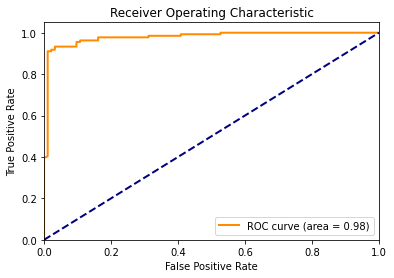

In [18]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

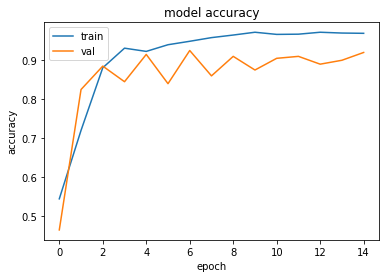

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

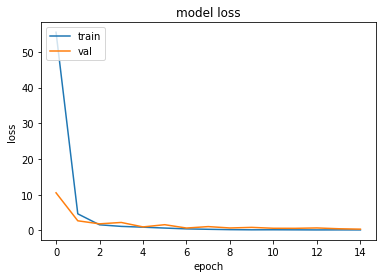

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)